# PROJECT-4. Решение комплексной бизнес-задачи 

**Цель проекта**
Для онлайн-школы подготовить основу рекомендательной системы, которая будет предлагать клиенту, положившему в корзину какой-либо курс, дополнительные курсы, которые могут заинтересовать этого клиента, и тем самым повышать средний чек. Такой основой должна быть таблица, в которой каждому курсу будет соответствовать по два дополнитеьных курса для рекомендации.
Иными словами, при выборе одного курса, клиент должен получить рекомендацию в виде двух дополнительных курсов. 
Основной критерий выбора дополнительных курсов в качестве рекомендации для некоторого курса - частотность заказа одним пользователем различных комбинаций курсов за прошедшее время работы школы (при этом не важно одновременно ли и в каком порядке эти курсы были заказаны). 1-ая рекомендация должна быть приоритетнее 2-ой.

**Требуется**
- Составить итоговую таблицу с рекомендациями, снабдив её необходимыми комментариями.

**Исходные данные**
Данные по заказам клинтов за прошедшее время содержатся в двух SQL-таблицах:
- Таблица carts — данные о пользовательских корзинах
  - Promo Code ID — ID промокода, если он есть
  - Purchased At — дата оплаты
  - User ID — ID пользователя
  - Created At — дата создания корзины
  - Updated At — дата последнего обновления информации
  - ID — идентификатор корзины
  - State — состояние оплаты
- Таблица cart items — данные о курсах, которые пользователи добавили в корзину
  - Created At — дата создания события
  - Resource Type — тип продукта
  - Resource ID — ID курса
  - Cart ID — идентификатор корзины
  - Updated At — дата последнего обновления информации
  - ID — идентификатор операции

## Предварительный анализ исходных таблиц средаствами SQL.

### Предварительный анализ таблицы carts.

С помощью Metabase получим иснформацию о столбцах таблицы:
![picture_of_bird](Carts_description.JPG)

In [1]:
import pandas as pd     # импорт Pandas для отображения ответов на SQL-запросы, сохраненных в виде файлов csv

_Посмотрим на количество не пустых значений в столбцах таблицы:_     
select   
    count(*) as table_row_cnt,  
    count(created_at) as created_at_cnt,  
    count(updated_at) as updated_at_cnt,  
    count(purchased_at) as purchased_at_cnt,  
    count(state) as state_cnt,  
    count(user_id) as user_id_cnt,  
    count(promo_code_id) as promo_code_id_cnt  
    from final.carts

In [2]:
display(pd.read_csv('query_result_Carts_cnts.csv'))

,table_row_cnt,created_at_cnt,updated_at_cnt,purchased_at_cnt,state_cnt,user_id_cnt,promo_code_id_cnt
0,93113,93113,93113,69717,93113,93113,3988


_Посомтрим на количество уникальных клиентов и уникальных промо-кодов:_

select count(distinct user_id) as uniq_user_id_cnt   
from final.carts

In [3]:
display(pd.read_csv('query_result_Carts_distinct_user_id_cnt.csv'))

,uniq_user_id_cnt
0,70254


select count(distinct promo_code_id) as uniq_promo_code_id_cnt  
from final.carts

In [4]:
display(pd.read_csv('query_result_Carts_uniq_promo_code_id_cnt.csv'))

,uniq_promo_code_id_cnt
0,327


_Посмотрим на перечень значений в столбце state:_  
select distinct state as uniq_states   
from final.carts

In [5]:
display(pd.read_csv('query_result_Carts_unuq_states.csv'))

,uniq_states
0,successful
1,created
2,pending


_Убедимся, что все корзины c отметкой о дате покупки имеют статус sucessful и что все корзины со статусом sucessful имеют отметкe о дате покупки:_  
select count(id) as not_correct_purchase_info_cnt   
from final.carts   
where (purchased_at is not null and state<>'successful') or (state='successful' and purchased_at is null)

In [6]:
display(pd.read_csv('query_result_Carts_bad_purchases.csv'))

,not_correct_purchase_info_cnt
0,0


*Убедимся что клиент может иметь более одной корзины со статусом successful:*  
select user_id, count(*) as purchased_bins_cnt 
from final.carts 
where state='successful'
group by user_id
having count(*) > 1

In [7]:
pd.set_option('display.max_rows', 4)
display(pd.read_csv('query_result_Carts_users_w_more_t_one_successful_bins.csv'))

,user_id,purchased_bins_cnt
0,1843278,5
1,1162286,3
...,...,...
12053,1134798,2
12054,737285,2


*Убедимся что клиент не может иметь более одной корзины со статусом отличным от successful:*  
select user_id, count(id) as created_and_pending_bins_cnt  
from final.carts   
where state='created' or state='pending'  
group by user_id  
having count(id) > 1  

In [8]:
display(pd.read_csv('query_result_Carts_users_w_more_t_one_not_successful_bins.csv'))

,user_id,created_and_pending_bins_cnt
0,106749,2
1,1145751,3
...,...,...
97,901859,5
98,748657,2


**Результаты предварительного анализа таблички carts:**
- столбцы created_at, updated_at, state, user_id полностью заполнены (не имеют пустых значений)
- столбец purchased_at имеет пустые значения, что не удивительно - не все клинеты оплатили продукты в своих корзинах; 3/4 корзин оплачены.
- столбец promo_code_id имеет пустые значения, что не удивительно - не все клинеты имеют промокоды; только 4% корзин ассоциированы с промокодами.
- задействованы 327 разных промокодов, т.е. в среднем один промокод приходится на чуть более 12 корзин.
- у одного клиента может быть несколько корзин, 
  - в частности, несколько корзин со статусом successful
  - в частности, несколько корзин (визуально наблюдаются значения от 2 до 5) м.б. в статусе отличным от succssful; 
  - в среднем на одного клиента приходится 1,3 корзины.
- имеющиеся варианты статуса корзины - created, pending и purchase.
- все корзины со статусом purchase имеют отметку о дате покупки; все корзины с отметкой о дате покупки имеют статус purchase 
  - (соответсвенно все корзины со статусом created или pending не имеют отметки о дате покупки; все корзины без отметки о дате покупки имеют статус created или pending)
  
**Выводы:**
В целом данные в таблице представляются корректными. При этом остаются неясными два момента:
- в чем разница между статусами корзины created и pending?
- каким образом у одного клиента могут появится несколько (в том чисе более 2-ух) корзин со статусами created и pending?

### Предварительный анализ таблицы cart_items.

С помощью Metabase получим иснформацию о столбцах таблицы:
![picture_of_bird](Cart_Items_description.JPG)

_Посмотрим на количество не пустых значений в столбцах таблицы:_     
select   
    count(*) as table_row_cnt,  
    count(cart_id) as cart_id_cnt,
    count(created_at) as created_at_cnt,  
    count(updated_at) as updated_at_cnt,  
    count(resource_type) as resource_type_cnt,  
    count(resource_id) as resource_id_cnt 
from final.cart_items

In [9]:
display(pd.read_csv('query_result_CartItems_cnts.csv'))

,table_row_cnt,cart_id_cnt,created_at_cnt,updated_at_cnt,resource_type_cnt,resource_id_cnt
0,100239,100239,100239,100239,100239,100239


_Посмотрим на перечень значений в столбце resource_type:_  
select distinct resource_type as uniq_resource_type   
from final.cart_items

In [10]:
display(pd.read_csv('query_result_uniq_resource_types.csv'))

,resource_type
0,Product
1,Course


*Проверим, нет ли в одной корзине нескольких ресурсов с одинаковым идентификатором:*  
select   
cart_id,   
count(resource_id) as resouce_id_cnt,   
count(distinct resource_id) as uniq_resouce_id_cnt  
from final.cart_items  
group by cart_id  
having count(resource_id)<>count(distinct resource_id)  

In [11]:
display(pd.read_csv('query_result_recourses_in_bins.csv'))

,cart_id,resouce_id_cnt,uniq_resouce_id_cnt
0,217369,3,2
1,220566,3,2
...,...,...,...
204,869690,2,1
205,958009,2,1


*Убедимся, что в одной корзине не может быть нескольких ресурсов **одного типа** с одинаковым идентификатором:*    
select   
cart_id,   
resource_type,   
count(resource_id) as resource_id_cnt,   
count(distinct resource_id) as uniq_resource_id_cnt  
from final.cart_items  
group by cart_id, resource_type  
having count(resource_id)<>count(distinct resource_id)

In [12]:
display(pd.read_csv('query_result_recourses_by_types_in_bins.csv'))

,cart_id,resource_type,resource_id_cnt,uniq_resource_id_cnt
0,217369,Course,3,2
1,220566,Course,3,2
...,...,...,...,...
203,869690,Course,2,1
204,958009,Course,2,1


*Проверим насколько независимы системы идентификации реусрсов разного типа:*    
with uniq_resource as (  
select   
distinct resource_id,   
resource_type   
from final.cart_items   
)  
select   
count(resource_id) as resource_id_cnt,   
count(distinct resource_id) as uniq_resource_id_cnt  
from uniq_resource  

In [13]:
display(pd.read_csv('query_result_resources_nbring_schemes.csv'))

,resource_id_cnt,uniq_resource_id_cnt
0,276,269


**Результаты предварительного анализа таблички cart_items:**
- все столбцы полностью заполнены (не имеют пустых значений)
- имеющиеся варианты типа ресурса - Product и Course.
- системы нумерации ресурсов типа Product и ресурсов типа Course независимы, т.е. могут встретится продукт и курс с одинаковым идентификатором
- в некоторых корзинах один и тот же ресурс присутствует несколько раз, например в одной корзине два раза может лежать один и тот же курс
  
**Выводы:**
В целом данные в таблице представляются корректными. При этом остаются неясными два момента:
- в чем разница между ресурсами типа Product и типа Course?
- каким образом в одной корзине один и тот же ресурс может лежать несколько раз?

### Предварительный анализ сочетаемости двух табличек

*Убедимся что перечень корзин полностью совпадает в двух табличках:*  
with   
carts_bins as (  
select distinct id from final.carts    
),  
cart_items_bins as (    
select distinct cart_id from final.cart_items    
)  
select   
count(*) as total_bins_cnt,  
count(id) as carts_bins_cnt,  
count(cart_id) as cart_items_bins_cnt  
from carts_bins full join cart_items_bins on id=cart_id

In [14]:
display(pd.read_csv('query_result_bins_in_two_tables.csv'))

,total_bins_cnt,carts_bins_cnt,cart_items_bins_cnt
0,93113,93113,93113


**Результаты предварительного анализа совместимости двух табличек:**
- две исходные таблицы содержат абсолютно одинаковый перечень корзин
  
**Выводы:**  
- Таблицы полностью совместимы друг с другом.

### Уточнение поставленной задачи
Появились новые вводные:
- для выработки рекомендаций следует использовать сведения только о корзинах со статусом successful
- система рекомендаций должна быть выработана только для ресурсов типа Course, учитывать ресурсы типа Product не требуется.

### Расчет числа всех фигурирующих в базе данных курсов и курсов, которые были хотя бы раз куплены.

*Количество всех фигурирующих в базе данных курсов:*    
select count(distinct resource_id) as all_courses_cnt  
from final.cart_items  
join final.carts on cart_id=carts.id  
where resource_type='Course'

In [15]:
display(pd.read_csv('query_result_all_courses_cnt.csv'))

,all_courses_cnt
0,127


*Количество курсов, которые были хотя бы раз куплены:*    
select count(distinct resource_id) as bought_courses_cnt   
from final.cart_items  
join final.carts on cart_id=carts.id  
where state='successful' and resource_type='Course'

In [16]:
display(pd.read_csv('query_result_bought_courses_cnt.csv'))

,bought_courses_cnt
0,126


**Результаты расчетов:**
- в таблицах представлены 127 уникальных курсов; из них 126 были куплены хотя бы по одному разу.
- возможно, для заказа доступны и другие курсы, которые не были ни разу положены в корзину и поэтому не фигурируют в таблицах.

## Выгрузка необходимых данных из SQL базы данных

Выгрузим из базы данных SQL нужные данные по курсам, оплаченным пользователями, купившими более одного курса и преобразуем ответ на запрос в формат DataFrame:

In [17]:
import psycopg2
import psycopg2.extras 

In [18]:
def data_from_sql():
    query = ''' 
        with 
            successful_courses as (
                select resource_id, user_id
                from final.cart_items
                join final.carts on cart_id=carts.id
                where state='successful' and resource_type='Course'),
            users_w_more_t_1_course as (
                select user_id from successful_courses
                group by user_id
                having count(resource_id)>1)
        select * from successful_courses
            where exists
            (select * from users_w_more_t_1_course 
            where successful_courses.user_id=users_w_more_t_1_course.user_id)
    '''         
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' \
        password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data
    
data_df = pd.DataFrame(data_from_sql())

print('Выгрузка из базы данных SQԼ - оплаченные курсы пользователей, купивших более одного курса:')
display(data_df)
data_df.info()

Выгрузка из базы данных SQԼ - оплаченные курсы пользователей, купивших более одного курса:


,resource_id,user_id
0,490,1010882
1,357,906674
...,...,...
34288,1144,164310
34289,513,1164493


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34290 entries, 0 to 34289
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   resource_id  34290 non-null  int64
 1   user_id      34290 non-null  int64
dtypes: int64(2)
memory usage: 535.9 KB


## Составление таблицы с рекомендациями дополнительных курсов.  
**Задача и требуемые принципы её решения:**  

Данная таблица должна стать основой рекомендательной системы.    
Суть рекомендательной системы - при выборе (помещении в корзину) одного курса, клиент должен получить рекомендацию в виде двух дополнительных курсов.  
 
В таблице каждому курсу должны быть поставлены в соответствовие два дополнительных курса для рекомендации.
Основной критерий выбора дополнительных курсов в качестве рекомендации для некоторого курса - частотность заказа одним пользователем различных комбинаций курсов за прошедшее время работы школы (при этом не важно одновременно ли и в каком порядке эти курсы были заказаны).  

Итоговая таблица должна состоять из трёх столбцов:  
  -  Курс, к которому идёт рекомендация.    
  -  Курс для рекомендации № 1 (наиболее часто встречающийся в совокупных заказах клиентов вместе с исходным курсом).  
  -  Курс для рекомендации № 2 (второй по встречаемости в совокупных заказах клиентов вместе с исходным курсом).  
    
В случае, если количество имеющихся сочетаний курсов слишком мало для составления рекомендации на этой основе, рекомендации могут быть составлены по другому принципу. 

### Составление перечня купленных пар курсов и количества покупок пар. Определение стратегии составления рекомендаций.

Посмотрим сколько было случаев повторной покупки клиентом одного и того же курса (или одновременной покупки курса в нескольких экземплярах):

In [19]:
data_df_duplicated_rows=data_df.duplicated()
display(data_df_duplicated_rows)
print('Число курсов, купленных клиентом один раз (False),\
    \nи число случаев повторной покупки клиентом одного и того же курса\
    \nили одновременной покупки курса в нескольких экземплярах (True)):')
print(data_df_duplicated_rows.value_counts())

0        False
1        False
         ...  
34288    False
34289    False
Length: 34290, dtype: bool

Число курсов, купленных клиентом один раз (False),    
и число случаев повторной покупки клиентом одного и того же курса    
или одновременной покупки курса в нескольких экземплярах (True)):
False    34133
True       157
dtype: int64


Число случаев дублированной покупки одного и того же курса ничтожно по сравнению с общим число покупок (157 по сравнению с 14290). При этом достоверность таких случаев вызывает сомнения. Поэтому избавимся от дублей покупок в данных.
Из полученного dataframe удалим дубликаты - случаи, когда один пользователь купил определенный курс несколько раз:

In [20]:
data_df.drop_duplicates(ignore_index=True,inplace=True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34133 entries, 0 to 34132
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   resource_id  34133 non-null  int64
 1   user_id      34133 non-null  int64
dtypes: int64(2)
memory usage: 533.5 KB


-----------------------------
*Примечание.*  
Может оказаться целесообразным выяснить причину многократных покупок одного и того же курса одним и тем же клиентом и определить, можно ли однозначно считать такое дублирование ошибкой в исходных данных. Для этого нужно выяснить следующее:
- были ли случаи опротестовывания подобных заказов или попыток отменить лишние покупки курса в заказе?
- позволяет ли клиентский интерфейс онлайн-заказов несколько раз положить один и тот же курс в одну корзину?
  - если нет, то мы наблюдаем ошибки в данных; имеет смысл выяснить причину таких ошибок
  - если да, то выяснить есть ли в этом практический смысл (например, возможно в паре с каждым курсом идет индивидуальный логин для подключения, и в этом случае клиент может купить дубль курса например для члена семьи)   
- позволяет ли клиентский интерфейс онлайн-заказов заказать курс повторно (при наличии таких случаев)?
  - если нет, то мы наблюдаем ошибки в данных; имеет смысл выяснить причину таких ошибок
  - если да, то выяснить есть ли в этом практический смысл (например, возможно материалы курса становятся недоступны клиенту после завершения обучения, а при этом клиенту может потребоваться такой доступ)   
-------------------------------------

Посмотрим сколько уникальных курсов было куплено клиентами, купившими более одного курса:

In [21]:
print('Количество уникальных курсов, купленных клиентами, купившими более одного курса :', \
    len(data_df['resource_id'].unique()))

Количество уникальных курсов, купленных клиентами, купившими более одного курса : 126


**Наблюдение:**  
Как было выяснено выше, всего в данных имеется 127 курсов, из которых 126 были куплены хотя бы один раз. 
Теперь видно, что каждый купленный курс был хотя бы раз куплен клиентом, имеющим несколько оплаченных курсов.

Для каждого клиента получим перечень купленных им курсов:

In [22]:
courses_of_users=[]
for user in data_df['user_id'].unique():
    user_courses=list(data_df[data_df['user_id']==user]['resource_id'])
    user_courses.sort()     # сортировка еще пригодится, например для определения уникальных перечней курсов одного пользователя
    courses_of_users.append(user_courses)
print('Перечнь купленных курсов для каждого клиента (без указания клиентов):')
from pprint import pprintpprint(courses_of_users) 

Перечнь купленных курсов для каждого клиента (без указания клиентов):


[[489, 490],
 [357, 551, 659],
 [489, 507, 519],
 [489, 507, 752, 777],
 [502, 514],
 [514, 552],
 [489, 502, 514, 515, 523, 551, 552],
 [489, 490],
 [489, 514, 523],
 [490, 514, 515],
 [366, 489, 502, 523, 551, 552, 679, 755, 764, 776, 809, 862, 1103],
 [523, 551],
 [515, 523],
 [551, 569, 572],
 [489, 564],
 [363, 511],
 [509, 553, 568, 745, 1139, 1147],
 [569, 572, 840],
 [359, 366],
 [356, 357, 514, 523, 551, 571],
 [507, 508, 752, 809],
 [516, 523, 551, 564, 745, 764],
 [551, 794],
 [489, 515, 552, 664, 764, 777],
 [357, 502],
 [551, 742],
 [552, 563, 776, 777],
 [490, 564],
 [490, 514, 566],
 [513, 551],
 [366, 504, 572],
 [490, 566],
 [489, 523, 572],
 [489, 515, 523, 551, 552],
 [509, 516, 553],
 [367, 368],
 [566, 1144],
 [551, 566, 1103],
 [552, 741, 756, 1102, 1115],
 [566, 776],
 [511, 514, 562, 794],
 [551, 794],
 [489, 503, 514, 551, 741],
 [515, 523],
 [507, 508],
 [516, 553, 1146],
 [490, 514],
 [368, 569, 840, 1100, 1101],
 [745, 777, 1100, 1102],
 [357, 571],
 [489, 4

Составим все имеющиеся пары курсов, встречающихся в заказе одного и того же клиента:

In [23]:
courses_pairs=[]
for combination in courses_of_users:
    for i in range(0,len(combination)-1):
        for j in range(i+1,len(combination)):
            courses_pairs.append([combination[i],combination[j]])
print('Количество пар курсов в заказе одного и того же клиента     : ', len(courses_pairs))
print('Пары курсов, встречающиеся в заказе одного и того же клиента:')
display(courses_pairs)

Количество пар курсов в заказе одного и того же клиента     :  40017
Пары курсов, встречающиеся в заказе одного и того же клиента:


[[489, 490],
 [357, 551],
 [357, 659],
 [551, 659],
 [489, 507],
 [489, 519],
 [507, 519],
 [489, 507],
 [489, 752],
 [489, 777],
 [507, 752],
 [507, 777],
 [752, 777],
 [502, 514],
 [514, 552],
 [489, 502],
 [489, 514],
 [489, 515],
 [489, 523],
 [489, 551],
 [489, 552],
 [502, 514],
 [502, 515],
 [502, 523],
 [502, 551],
 [502, 552],
 [514, 515],
 [514, 523],
 [514, 551],
 [514, 552],
 [515, 523],
 [515, 551],
 [515, 552],
 [523, 551],
 [523, 552],
 [551, 552],
 [489, 490],
 [489, 514],
 [489, 523],
 [514, 523],
 [490, 514],
 [490, 515],
 [514, 515],
 [366, 489],
 [366, 502],
 [366, 523],
 [366, 551],
 [366, 552],
 [366, 679],
 [366, 755],
 [366, 764],
 [366, 776],
 [366, 809],
 [366, 862],
 [366, 1103],
 [489, 502],
 [489, 523],
 [489, 551],
 [489, 552],
 [489, 679],
 [489, 755],
 [489, 764],
 [489, 776],
 [489, 809],
 [489, 862],
 [489, 1103],
 [502, 523],
 [502, 551],
 [502, 552],
 [502, 679],
 [502, 755],
 [502, 764],
 [502, 776],
 [502, 809],
 [502, 862],
 [502, 1103],
 [523, 55

Получим перечень уникальных пар курсов, встречающихся в заказе одного и того же клиента:

In [24]:
# алгоритм работы данного кода такой же, как и выше. Но использование множества позволяет оставить только уникальные пары. \
    # Напомню, что в рамках каждого клиента курсы отсортированы, поэтому порядок следования курсов в каждой паре всегда одинаков
uniq_courses_pairs=set()
for combination in courses_of_users:
    for i in range(0,len(combination)-1):
        for j in range(i+1,len(combination)):
            uniq_courses_pairs.add((combination[i],combination[j]))
print('Количество уникальных пар курсов, встречающихся в заказе одного и того же клиента : ', len(uniq_courses_pairs))
print('Уникальные пары курсов, встречающихся в заказе одного и того же клиента:')
display(uniq_courses_pairs)

Количество уникальных пар курсов, встречающихся в заказе одного и того же клиента :  3989
Уникальные пары курсов, встречающихся в заказе одного и того же клиента:


{(504, 814),
 (564, 865),
 (489, 1100),
 (791, 907),
 (863, 1161),
 (356, 570),
 (776, 864),
 (814, 1156),
 (515, 743),
 (909, 1128),
 (835, 1099),
 (514, 864),
 (659, 1102),
 (356, 835),
 (504, 670),
 (568, 1100),
 (777, 865),
 (514, 1129),
 (1103, 1115),
 (569, 570),
 (356, 1100),
 (757, 1115),
 (519, 569),
 (516, 909),
 (829, 1140),
 (502, 745),
 (515, 864),
 (502, 516),
 (513, 791),
 (514, 756),
 (862, 908),
 (365, 776),
 (366, 741),
 (794, 810),
 (358, 508),
 (515, 1129),
 (1125, 1138),
 (504, 562),
 (1104, 1115),
 (863, 1138),
 (519, 1099),
 (863, 909),
 (571, 1146),
 (745, 1182),
 (813, 908),
 (366, 368),
 (361, 1156),
 (513, 1141),
 (1129, 1144),
 (794, 1160),
 (360, 553),
 (366, 862),
 (659, 1115),
 (361, 518),
 (507, 572),
 (1128, 1185),
 (364, 523),
 (489, 1198),
 (490, 519),
 (363, 564),
 (1103, 1128),
 (566, 1152),
 (368, 679),
 (908, 1181),
 (752, 1199),
 (757, 1128),
 (357, 749),
 (366, 489),
 (363, 829),
 (507, 1102),
 (523, 552),
 (562, 809),
 (551, 1145),
 (367, 570),

Преобразуем список пар курсов в таблицу-DataFrame (с указанием количества покупок каждой пары):

In [25]:
courses_pairs_df=pd.DataFrame({'courses_pair':courses_pairs})
print('Промежуточный DataFrame։')
display(courses_pairs_df)
courses_pairs_cnt=courses_pairs_df['courses_pair'].value_counts()
courses_pairs_df=courses_pairs_cnt.to_frame().reset_index()
print('Промежуточный DataFrame։')
display(courses_pairs_df)
courses_pairs_df.rename(columns={'courses_pair':'pair_cnt','index':'courses_pair'},inplace=True)
print('Таблица с уникальными парами курсов и количеством их покупок, отсортированный по количеству покупок։')
    # поскольку dataframe основан на выводе ․value_counts(), \
        # то пары в нем отсортированы по количеству покупок по убыванию
display(courses_pairs_df)

Промежуточный DataFrame։


,courses_pair
0,"[489, 490]"
1,"[357, 551]"
...,...
40015,"[364, 551]"
40016,"[356, 568]"


Промежуточный DataFrame։


,index,courses_pair
0,"[551, 566]",797
1,"[515, 551]",417
...,...,...
3987,"[519, 1124]",1
3988,"[572, 664]",1


Таблица с уникальными парами курсов и количеством их покупок, отсортированный по количеству покупок։


,courses_pair,pair_cnt
0,"[551, 566]",797
1,"[515, 551]",417
...,...,...
3987,"[519, 1124]",1
3988,"[572, 664]",1


Посмотрим на распределение количества покупок уникальных пар курсов:

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

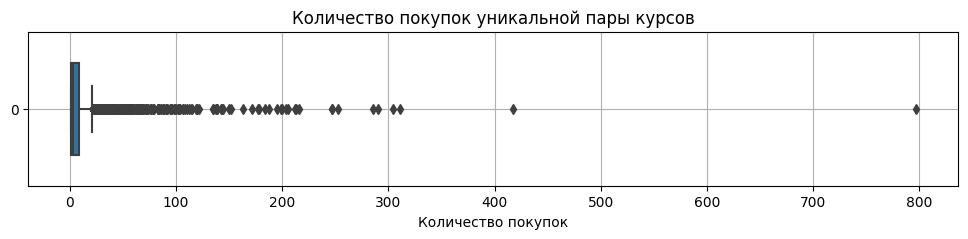

In [27]:
fig_pairs_cnt = plt.figure(figsize=(12, 2))
boxplot = sns.boxplot(
    data=courses_pairs_df['pair_cnt'],
    orient='h',
    width=0.6
)
boxplot.set_title('Количество покупок уникальной пары курсов');
boxplot.set_xlabel('Количество покупок');
boxplot.grid();
boxplot.set_axisbelow(True);

Посмотрим на статистические параметры столбца с количеством покупок уникальной пары курсов:

In [28]:
pd.set_option('display.max_rows', 12)
print('Общее статистическое описание:')
display(courses_pairs_df['pair_cnt'].agg('describe'))
print('Мода :  ', courses_pairs_df['pair_cnt'].mode()[0])

Общее статистическое описание:


count    3989.000000
mean       10.031838
std        26.355998
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       797.000000
Name: pair_cnt, dtype: float64

Мода :   1


Расчитаем межквартильный размах и границы выбросов:

In [29]:
iqr = courses_pairs_df['pair_cnt'].quantile(0.75) - courses_pairs_df['pair_cnt'].quantile(0.25)
lo_outlier_border = courses_pairs_df['pair_cnt'].quantile(0.25) - 1.5*iqr
hi_outlier_border = courses_pairs_df['pair_cnt'].quantile(0.75) + 1.5*iqr
print('IQR                      : ', iqr)
print('Граница нижних выбросов  :', lo_outlier_border)
print('Граница верхних выбросов : ', hi_outlier_border)

IQR                      :  8.0
Граница нижних выбросов  : -11.0
Граница верхних выбросов :  21.0


Отобразим распределение количества покупок уникальных пар курсов, сфокусировавшись на основной его части (без выбросов):

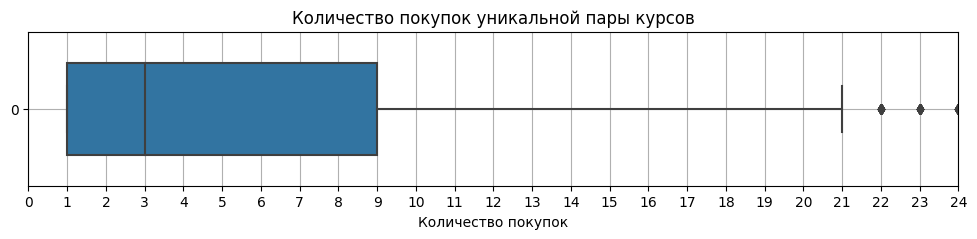

In [30]:
fig_pairs_cnt = plt.figure(figsize=(12, 2))
boxplot = sns.boxplot(
    data=courses_pairs_df['pair_cnt'],
    orient='h',
    width=0.6,
)
boxplot.set_xlim([0,24])
boxplot.set_title('Количество покупок уникальной пары курсов');
boxplot.set_xlabel('Количество покупок');
boxplot.grid();
boxplot.set_xticks(list(range(0,25))); 
boxplot.set_axisbelow(True);

Посмотрим какой процент пар повторяется то или иное число раз:

In [31]:
print('Всего пар                            : ', courses_pairs_df.shape[0], ', 100 %')
print('Пары, встречающиеся 1 раз            : ', courses_pairs_df[courses_pairs_df['pair_cnt']==1].shape[0], ',', \
    round(courses_pairs_df[courses_pairs_df['pair_cnt']==1].shape[0] / courses_pairs_df.shape[0] *100), '%')
print('Пары, встречающиеся 2 раза           : ', courses_pairs_df[courses_pairs_df['pair_cnt']==2].shape[0], ' ,', \
    round(courses_pairs_df[courses_pairs_df['pair_cnt']==2].shape[0] / courses_pairs_df.shape[0] *100), '%')
print('Пары, встречающиеся 3 раза           : ', courses_pairs_df[courses_pairs_df['pair_cnt']==3].shape[0], ' ,', \
    round(courses_pairs_df[courses_pairs_df['pair_cnt']==3].shape[0] / courses_pairs_df.shape[0] *100), '%')
print('Пары, встречающиеся от 4 до 8 раз    : ', \
    courses_pairs_df[(courses_pairs_df['pair_cnt']>3) & (courses_pairs_df['pair_cnt']<9)].shape[0], ' ,', \
    round(courses_pairs_df[(courses_pairs_df['pair_cnt']>3) & (courses_pairs_df['pair_cnt']<9)].shape[0] \
        / courses_pairs_df.shape[0] *100), '%')
print('Пары, встречающиеся 9 раз            : ', courses_pairs_df[courses_pairs_df['pair_cnt']==9].shape[0], '  ,', \
    round(courses_pairs_df[courses_pairs_df['pair_cnt']==9].shape[0] / courses_pairs_df.shape[0] *100), '%')
print('Пары, встречающиеся от 10 до 21 раза : ', \
    courses_pairs_df[(courses_pairs_df['pair_cnt']>9) & (courses_pairs_df['pair_cnt']<22)].shape[0], ' ,', \
    round(courses_pairs_df[(courses_pairs_df['pair_cnt']>9) & (courses_pairs_df['pair_cnt']<22)].shape[0] \
        / courses_pairs_df.shape[0] *100), '%')
print('Пары, встречающиеся более 21 раза    : ', courses_pairs_df[courses_pairs_df['pair_cnt']>21].shape[0], ' ,', \
    round(courses_pairs_df[courses_pairs_df['pair_cnt']>21].shape[0] / courses_pairs_df.shape[0] *100), '%')

Всего пар                            :  3989 , 100 %
Пары, встречающиеся 1 раз            :  1185 , 30 %
Пары, встречающиеся 2 раза           :  578  , 14 %
Пары, встречающиеся 3 раза           :  366  , 9 %
Пары, встречающиеся от 4 до 8 раз    :  852  , 21 %
Пары, встречающиеся 9 раз            :  80   , 2 %
Пары, встречающиеся от 10 до 21 раза :  521  , 13 %
Пары, встречающиеся более 21 раза    :  407  , 10 %


**Определение количества повторов пар, начиная с которого пары следует учитывать как единственный фактор при составлении рекомендаций.**  
Составлять рекомендации только на основе популярности покупок курсов в паре будем только для тех пар, которые были куплены не менее трех раз. Такая тактика обусловлена следующими соображениями:  
- однократная покупка пары представляется случайным событием;
- двухкратная покупка пары также сама по себе не является показательной;
- учет пар начиная с трёх повторов и более позволяет придерживаться желаемого принципа подбора рекомендаций - максимально возможно учитывать совместные покупки пар курсов одним клиентам - бо'льшая часть пар будет использована при составлении рекомендаций.

### Составим рекомендации для всех возможных курсов на основе пар, купленных 3 и более раз.

Уберем пары, встречающиеся менее трёх раз:

In [32]:
courses_pairs_w_cnt_more_t_2_df=courses_pairs_df[courses_pairs_df['pair_cnt']>2]
pd.set_option('display.max_rows', 4)
print('Таблица с уникальными парами курсов, купленными 3 и более раз, и количеством их покупок:')
display(courses_pairs_w_cnt_more_t_2_df)

Таблица с уникальными парами курсов, купленными 3 и более раз, и количеством их покупок:


,courses_pair,pair_cnt
0,"[551, 566]",797
1,"[515, 551]",417
...,...,...
2224,"[571, 1102]",3
2225,"[865, 1100]",3


Из списка курсов, оплаченных пользователями, купившими более одного курса, получим перечень курсов:

In [33]:
courses_list=data_df['resource_id'].unique()
print('Перечень уникальных курсов, оплаченных пользователями, купившими более одного курса:')
display(courses_list)
print('Количество уникальных курсов, оплаченных пользователями, купившими более одного курса :',  len(courses_list))

Перечень уникальных курсов, оплаченных пользователями, купившими более одного курса:


array([ 490,  357,  507,  489,  514,  552,  515,  523,  569,  363,  553,
        572,  502,  359,  551,  809,  516,  563,  513,  504,  509,  368,
       1144,  776,  741,  508,  777,  745,  362,  566,  356,  794,  358,
        519,  742,  679, 1103,  503,  750,  564,  361,  571,  562,  752,
        367,  756, 1104,  360,  364,  764,  670,  743,  753,  659,  366,
        568,  518, 1102,  862,  570,  791, 1116, 1101, 1100,  664,  511,
        365,  840,  517, 1141, 1128,  757, 1146, 1152,  749,  829,  744,
        909,  810,  755,  765, 1099, 1139,  908, 1129,  814,  837,  912,
       1145,  672, 1147, 1125, 1138, 1140,  803, 1188, 1161, 1184,  813,
        907,  671, 1156, 1115, 1124, 1187, 1181,  864, 1186,  863,  830,
        835,  800,  833,  866,  865,  911, 1185,  834,  836, 1182, 1200,
       1198, 1199,  902, 1160, 1201], dtype=int64)

Количество уникальных курсов, оплаченных пользователями, купившими более одного курса : 126


Начнем составлять словарь *course_pairs_matrix* - прототип таблицы рекомендаций:  
- ключами словаря будут курсы;
- значениями - списки рекомендованных дополнительных курсов, 1-ым в списке будет идти приоритетная рекомендация, 2-ым - менее приоритетная.  

Принцип подбора рекомендаций - количество покупок пар курсов.
Пока в словаре будут только купленные курсы, а рекомендации будут взяты только из пар, купленных не менее 3 раз. 

In [34]:
# помним, что courses_pairs_df, а значит и courses_pairs_w_cnt_more_t_2_df \
    # остортированы по количеству покупок пар по убыванию
# при наличии более двух равноправных кандидатов в рекомендации для курса \
    # или двух и более равноправных кандидатов во 2-ую рекомендацию \
    # (курс входит в несколько пар с одинаковым числом повторов пары), \
    # выбор будет случайным (вслед за сделанной сортировкой датафрейма по количеству покупок пар)
course_pairs_matrix={}
for course_pair in courses_pairs_w_cnt_more_t_2_df['courses_pair']:
    #print(course_pair) 
    if course_pair[0] not in course_pairs_matrix.keys():
        #print('if1')
        course_pairs_matrix[course_pair[0]] = [course_pair[1]]
        #print(course_pairs_matrix)
    elif len(course_pairs_matrix[course_pair[0]]) == 1:
        #print('elif1')
        course_pairs_matrix[course_pair[0]].append(course_pair[1])
        #print(course_pairs_matrix)
    if course_pair[1] not in course_pairs_matrix.keys():
        #print('if2')
        course_pairs_matrix[course_pair[1]] = [course_pair[0]]
        #print(course_pairs_matrix)
    elif len(course_pairs_matrix[course_pair[1]]) == 1:
        #print('elif2')
        course_pairs_matrix[course_pair[1]].append(course_pair[0])
        #print(course_pairs_matrix)    
print('Словарь - прототип таблицы рекомендаций:')
display(course_pairs_matrix)

Словарь - прототип таблицы рекомендаций:


{551: [566, 515],
 566: [551, 794],
 515: [551, 489],
 489: [551, 515],
 523: [551, 515],
 794: [566, 551],
 490: [566, 551],
 570: [752, 507],
 752: [570, 507],
 569: [572, 840],
 572: [569, 504],
 553: [745, 516],
 745: [553, 516],
 840: [569, 572],
 514: [551, 515],
 516: [745, 553],
 504: [572, 569],
 552: [551, 523],
 507: [570, 752],
 809: [490, 570],
 502: [551, 566],
 571: [1125, 357],
 1125: [571, 912],
 357: [571, 356],
 564: [523, 551],
 749: [551, 515],
 777: [551, 515],
 679: [551, 489],
 356: [571, 357],
 568: [745, 553],
 363: [511, 562],
 511: [363, 562],
 764: [566, 551],
 519: [551, 523],
 765: [571, 1125],
 562: [363, 511],
 1103: [551, 566],
 912: [571, 1125],
 1115: [570, 752],
 1139: [745, 553],
 1161: [840, 569],
 743: [490, 757],
 750: [551, 566],
 366: [551, 515],
 508: [507, 570],
 503: [551, 513],
 509: [745, 553],
 664: [551, 503],
 513: [503, 551],
 1099: [568, 745],
 563: [562, 363],
 517: [551, 750],
 776: [551, 566],
 741: [551, 566],
 659: [551, 566],
 

In [35]:
# определим сколько курсов-ключей попали в словарь, сколько из них имеют полную рекомендацию (из двух курсов), \
    # сколько - частичную (только 1 рекомендованный курс), сколько не имеют рекомедаций (таких быть не должно)
full_rec=0
half_rec=0
no_rec=0
for key in course_pairs_matrix.keys():
    if len(course_pairs_matrix[key]) == 2:
        full_rec = full_rec +1
    elif len(course_pairs_matrix[key]) == 1:
        half_rec = half_rec +1
    else:
        no_rec = no_rec +1
print('Количество курсов, попавших в ключи словаря                        :', len(course_pairs_matrix))
print('из них:')
print(' количество ключей-курсов, имеющих полный набор рекомендаций (2)   :', full_rec)
print(' количество ключей-курсов, имеющих неполный набор рекомендаций (1) :', half_rec)
print(' количество ключей-курсов, имеющих пустой набор рекомендаций (0)   :', no_rec)

Количество курсов, попавших в ключи словаря                        : 118
из них:
 количество ключей-курсов, имеющих полный набор рекомендаций (2)   : 117
 количество ключей-курсов, имеющих неполный набор рекомендаций (1) : 1
 количество ключей-курсов, имеющих пустой набор рекомендаций (0)   : 0


**Итого**, имеем в ключах словаря 118 курсов из 126 (127).  
Для всех этих 118 курсов рекомендация состоит минимум из одного дополнительного курса (1-ый приоритет):
- количество ключей-курсов, имеющих полный набор рекомендаций (2)   : 117
- количество ключей-курсов, имеющих неполный набор рекомендаций (1) : 1
- количество ключей-курсов, имеющих пустой набор рекомендаций (0)   : 0

### Рекомендации на основе пар курсов, купленных 2 раза.
**Стратегия**  
При составлении рекомендаций будем учитывать такие пары только в следующих случаях:
- парный курс можно брать в качестве 1-ой или 2-ой рекомендации когда доля покупок основного курса в такой паре в общем количестве покупок данного курса не меньше (т.е. при равенстве долей приоритет - за курсом из пары, поскольку это является основным принципом составления таблицы рекомендаций) доли покупок самого популярного курса в общем числе покупок отдельных курсов;
- парный курс можно брать в качестве 2-ой рекомендации когда доля покупок основного курса в такой паре в общем количестве покупок данного курса не меньше доли покупок 2-го по популярности курса в общем числе покупок отдельных курсов.

При этом при наличии нескольких кандидатов из таких пар в качестве рекомендаций будем брать курсы с наибольшей долей покупок среди покупок основного курса. При одинаковой доле - курсы с большей популярностью в покупках в целом.   

Получим перечень ВСЕХ покупок курсов с указанием пользователя:

In [36]:
def data_from_sql_all_bought_courses():
    query2 = ''' 
        select resource_id, user_id
        from final.cart_items
        join final.carts on cart_id=carts.id
        where state='successful' and resource_type='Course'
    '''         
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' \
        password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query2)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data
    
all_bought_courses_df = pd.DataFrame(data_from_sql_all_bought_courses())

print('Выгрузка из базы данных SQԼ - перечень всех покупок курсов:')
display(all_bought_courses_df)
all_bought_courses_df.info()

Выгрузка из базы данных SQԼ - перечень всех покупок курсов:


,resource_id,user_id
0,490,1010882
1,357,906674
...,...,...
70579,513,1164493
70580,551,1171337


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70581 entries, 0 to 70580
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   resource_id  70581 non-null  int64
 1   user_id      70581 non-null  int64
dtypes: int64(2)
memory usage: 1.1 MB


Посмотрим сколько было случаев повторной покупки клиентом одного и того же курса (или одновременной покупки курса в нескольких экземплярах):

In [37]:
all_bought_courses_df_duplicated_rows=all_bought_courses_df.duplicated()
display(all_bought_courses_df_duplicated_rows)
print('Число курсов, купленных клиентом один раз (False),\
    \nи число случаев повторной покупки клиентом одного и того же курса (True)):')
print(all_bought_courses_df_duplicated_rows.value_counts())

0        False
1        False
         ...  
70579    False
70580    False
Length: 70581, dtype: bool

Число курсов, купленных клиентом один раз (False),    
и число случаев повторной покупки клиентом одного и того же курса (True)):
False    70424
True       157
dtype: int64


Число случаев дублированной покупки одного и того же курса (157) ничтожно по сравнению с общим число покупок (70581). При этом достоверность таких случаев вызывает сомнения. Поэтому избавимся от дублей покупок в данных.
Из полученного dataframe удалим дубликаты - случаи, когда один пользователь купил определенный курс несколько раз:

In [38]:
all_bought_courses_df.drop_duplicates(ignore_index=True,inplace=True)
all_bought_courses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70424 entries, 0 to 70423
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   resource_id  70424 non-null  int64
 1   user_id      70424 non-null  int64
dtypes: int64(2)
memory usage: 1.1 MB


Определим количество покупок каждого курса:

In [39]:
course_bought_cnt = all_bought_courses_df['resource_id'].value_counts()
print('Промежуточная серия:')
display(course_bought_cnt)
course_bought_cnt_df=course_bought_cnt.to_frame().reset_index().sort_values('index')
print('Промежуточный DataFrame:')
display(course_bought_cnt_df)
course_bought_cnt_df.rename(columns={'index':'course','resource_id':'bought_cnt'}, inplace=True)
print('Таблица с числом покупок каждого курса:')
display(course_bought_cnt_df)

Промежуточная серия:


551     9564
566     6216
        ... 
1200       2
1199       2
Name: resource_id, Length: 126, dtype: int64

Промежуточный DataFrame:


,index,resource_id
26,356,659
25,357,761
...,...,...
124,1200,2
123,1201,5


Таблица с числом покупок каждого курса:


,course,bought_cnt
26,356,659
25,357,761
...,...,...
124,1200,2
123,1201,5


Построим диаграмму, показывающую количество покупок каждого курса:

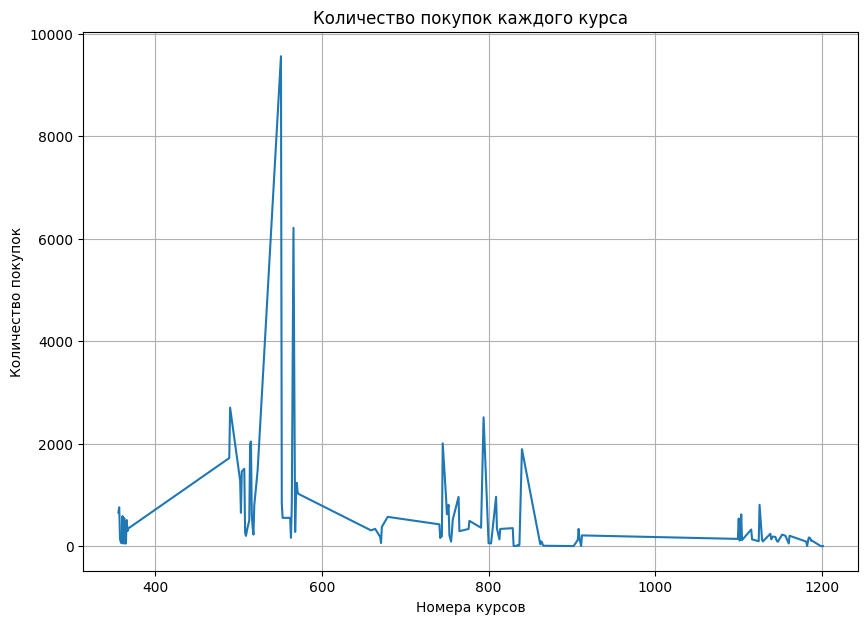

In [40]:
plt.figure(figsize=(10,7)) 
plt.plot(course_bought_cnt_df['course'], course_bought_cnt_df['bought_cnt']) 
plt.title('Количество покупок каждого курса')
plt.xlabel('Номера курсов')
plt.ylabel('Количество покупок')
plt.grid(True) # Выводим сетку на график
plt.show() # Выводим график на экран

**Наблюдение:**  
Как видно из диаграммы, курсы с низкими номерами покупают чаще чем курсы с высокими номерами.

Найдем два самых популярных с точки зрения числа покупок курса (не учитывая дублированные покупки курса одним и тем же пользователем - дубликаты были ранее удалены из наших таблиц):

In [41]:
print('Таблица с числом покупок каждого курса:')
display(course_bought_cnt_df)
two_most_popular_courses=course_bought_cnt_df.nlargest(2, columns='bought_cnt')
print('Два самых популярных курса:')
display(two_most_popular_courses)

Таблица с числом покупок каждого курса:


,course,bought_cnt
26,356,659
25,357,761
...,...,...
124,1200,2
123,1201,5


Два самых популярных курса:


,course,bought_cnt
0,551,9564
1,566,6216


Определим долю покупок двух самых популярных курсов в общем числе покупок:

In [42]:
two_most_popular_courses['%_all_bought'] \
    = round(two_most_popular_courses['bought_cnt'] / course_bought_cnt_df['bought_cnt'].sum() * 100, 2)
display(two_most_popular_courses)

,course,bought_cnt,%_all_bought
0,551,9564,13.58
1,566,6216,8.83


Получим перечень пар курсов, купленных два раза:

In [43]:
courses_pairs_w_cnt_2_df=courses_pairs_df[courses_pairs_df['pair_cnt']==2]
pd.set_option('display.max_rows', 4)
print('Таблица с парами курсов, купленными два раза:')
display(courses_pairs_w_cnt_2_df)

Таблица с парами курсов, купленными два раза:


,courses_pair,pair_cnt
2226,"[562, 1116]",2
2227,"[752, 1124]",2
...,...,...
2802,"[829, 1144]",2
2803,"[1116, 1144]",2


Получим второй экземпляр таблицы с парами курсов, купленными два раза, и переставим курсы внутри каждой пары местами:

In [44]:
courses_pairs_w_cnt_2_df_mirrored = courses_pairs_w_cnt_2_df.copy() 
courses_pairs_w_cnt_2_df_mirrored['courses_pair'] = \
    courses_pairs_w_cnt_2_df_mirrored['courses_pair'].apply(lambda pair : pair[::-1])    # x.reverse())
print('Второй экземпляр таблицы с парами курсов, купленными два раза, с обратным порядком следования курсов в каждой паре:')
display(courses_pairs_w_cnt_2_df_mirrored)

Второй экземпляр таблицы с парами курсов, купленными два раза, с обратным порядком следования курсов в каждой паре:


,courses_pair,pair_cnt
2226,"[1116, 562]",2
2227,"[1124, 752]",2
...,...,...
2802,"[1144, 829]",2
2803,"[1144, 1116]",2


Объединим вертикально оба экземпляра таблицы с парами курсов, купленными два раза:

In [45]:
courses_pairs_w_cnt_2_df_doubled = pd.concat([courses_pairs_w_cnt_2_df, courses_pairs_w_cnt_2_df_mirrored], \
    axis=0, join='outer', ignore_index=True)
print('Объединенная таблица с парами курсов, купленными два раза.\nВ таблице каждая пара фигурирует два раза - \
с прямым и обратным порядком курсов.')
display(courses_pairs_w_cnt_2_df_doubled)

Объединенная таблица с парами курсов, купленными два раза.
В таблице каждая пара фигурирует два раза - с прямым и обратным порядком курсов.


,courses_pair,pair_cnt
0,"[562, 1116]",2
1,"[752, 1124]",2
...,...,...
1154,"[1144, 829]",2
1155,"[1144, 1116]",2


Напишем и применим функцию, добавляющую к таблице общее количество покупок 1-го курса и общее количество покупок 2-го курса каждой пары и и применим ее к таблице:

In [46]:
def course1_bought_cnt(row, course_bought_cnt_):
    row['1st_course_bought_cnt']=course_bought_cnt_[row['courses_pair'][0]]
    row['2nd_course_bought_cnt']=course_bought_cnt_[row['courses_pair'][1]]
    return row
courses_pairs_w_cnt_2_df_doubled = courses_pairs_w_cnt_2_df_doubled.apply( \
    lambda row: course1_bought_cnt(row, course_bought_cnt), axis=1)
print('Таблица с парами курсов, купленными два раза, и указанием количества покупок каждого курса каждой пары:')
display(courses_pairs_w_cnt_2_df_doubled)

Таблица с парами курсов, купленными два раза, и указанием количества покупок каждого курса каждой пары:


,courses_pair,pair_cnt,1st_course_bought_cnt,2nd_course_bought_cnt
0,"[562, 1116]",2,556,136
1,"[752, 1124]",2,809,99
...,...,...,...,...
1154,"[1144, 829]",2,184,355
1155,"[1144, 1116]",2,184,136


Добавим в таблицу долю покупок 1-го курса в данной паре в общем числе покупок этого курса. И отсортируем строки таблицы в порядке убывания этой доли, а при равенстве долей у разных курсов - в порядке убывания общей популярности 2-го курса пары:

In [47]:
courses_pairs_w_cnt_2_df_doubled['pair_cnt_%_1st_course_bought_cnt'] \
    = round(courses_pairs_w_cnt_2_df_doubled['pair_cnt'] / courses_pairs_w_cnt_2_df_doubled['1st_course_bought_cnt'] * 100, 2) 
courses_pairs_w_cnt_2_df_doubled.sort_values(by=['pair_cnt_%_1st_course_bought_cnt', '2nd_course_bought_cnt'], \
    ascending=[False,False], inplace= True)   
display(courses_pairs_w_cnt_2_df_doubled)

,courses_pair,pair_cnt,1st_course_bought_cnt,2nd_course_bought_cnt,pair_cnt_%_1st_course_bought_cnt
611,"[1199, 523]",2,2,1480,100.00
1100,"[911, 514]",2,6,2000,33.33
...,...,...,...,...,...
16,"[551, 837]",2,9564,31,0.02
424,"[551, 835]",2,9564,26,0.02


Выберем из таблицы только те пары, в которых доля покупки 1-го курса пары в общем числе покупок этого курса равна или превышает долю покупок самого популярного курса в общем числе покупок отдельных курсов:

In [48]:
very_good_pairs_df = courses_pairs_w_cnt_2_df_doubled[ \
    courses_pairs_w_cnt_2_df_doubled['pair_cnt_%_1st_course_bought_cnt'] >= two_most_popular_courses.loc[0,'%_all_bought']]
display(very_good_pairs_df)

,courses_pair,pair_cnt,1st_course_bought_cnt,2nd_course_bought_cnt,pair_cnt_%_1st_course_bought_cnt
611,"[1199, 523]",2,2,1480,100.00
1100,"[911, 514]",2,6,2000,33.33
...,...,...,...,...,...
168,"[866, 1104]",2,11,122,18.18
1084,"[866, 865]",2,11,26,18.18


Воспользуемся полученной таблицей для пополнения словаря рекомендаций:  
- Добавим в словарь рекомендаций в качестве ключей те курсы из таблицы, к-рых нет в словаре. 
- При этом у таких добавленных курсов сразу появится как минимум 1-ая рекомендация - курс, который для нашего курса оказался не менее популярным чем самый популярный курс в общем числе покупок.
- Возможно, для некотрых добавленных ключей-курсов, а также для уже присутствововавших в словаре ключей-куров, добавится 2-ая рекомендация.
- В качестве рекомендаций здесь будут использованы курсы, чья популярность для курсов-ключей оказалась не меньшей чем  популярность самого популярного курса в общем числе покупок.
- При наличии нескольких кандидатов в рекомендацию будет выбран курс с наивысшей популярностью в общем числе покупок.

  Под популярностью здесь понимается доля в покупках.

In [49]:
for course_pair in very_good_pairs_df['courses_pair']:
    if course_pair[0] not in course_pairs_matrix.keys():
        course_pairs_matrix[course_pair[0]] = [course_pair[1]]
    elif len(course_pairs_matrix[course_pair[0]]) == 1:
        course_pairs_matrix[course_pair[0]].append(course_pair[1])
print('Словарь - прототип таблицы рекомендаций:')
display(course_pairs_matrix)

Словарь - прототип таблицы рекомендаций:


{551: [566, 515],
 566: [551, 794],
 515: [551, 489],
 489: [551, 515],
 523: [551, 515],
 794: [566, 551],
 490: [566, 551],
 570: [752, 507],
 752: [570, 507],
 569: [572, 840],
 572: [569, 504],
 553: [745, 516],
 745: [553, 516],
 840: [569, 572],
 514: [551, 515],
 516: [745, 553],
 504: [572, 569],
 552: [551, 523],
 507: [570, 752],
 809: [490, 570],
 502: [551, 566],
 571: [1125, 357],
 1125: [571, 912],
 357: [571, 356],
 564: [523, 551],
 749: [551, 515],
 777: [551, 515],
 679: [551, 489],
 356: [571, 357],
 568: [745, 553],
 363: [511, 562],
 511: [363, 562],
 764: [566, 551],
 519: [551, 523],
 765: [571, 1125],
 562: [363, 511],
 1103: [551, 566],
 912: [571, 1125],
 1115: [570, 752],
 1139: [745, 553],
 1161: [840, 569],
 743: [490, 757],
 750: [551, 566],
 366: [551, 515],
 508: [507, 570],
 503: [551, 513],
 509: [745, 553],
 664: [551, 503],
 513: [503, 551],
 1099: [568, 745],
 563: [562, 363],
 517: [551, 750],
 776: [551, 566],
 741: [551, 566],
 659: [551, 566],
 

In [50]:
full_rec=0
half_rec=0
no_rec=0
for key in course_pairs_matrix.keys():
    if len(course_pairs_matrix[key]) == 2:
        full_rec = full_rec +1
    elif len(course_pairs_matrix[key]) == 1:
        half_rec = half_rec +1
    else:
        no_rec = no_rec +1
print('Количество курсов, попавших в ключи словаря                        :', len(course_pairs_matrix))
print('из них:')
print(' количество ключей-курсов, имеющих полный набор рекомендаций (2)   :', full_rec)
print(' количество ключей-курсов, имеющих неполный набор рекомендаций (1) :', half_rec)
print(' количество ключей-курсов, имеющих пустой набор рекомендаций (0)   :', no_rec)

Количество курсов, попавших в ключи словаря                        : 122
из них:
 количество ключей-курсов, имеющих полный набор рекомендаций (2)   : 119
 количество ключей-курсов, имеющих неполный набор рекомендаций (1) : 3
 количество ключей-курсов, имеющих пустой набор рекомендаций (0)   : 0


В ключи словаря добавлены еще 4 курса.  

**Итого**, имеем в ключах словаря 122 курса из 126 курсов, которые были куплены хотя бы раз, или из 127 курсов, наблюдаемых в базе данных.  
Для всех этих 122 курсов рекомендация состоит минимум из одного дополнительного курса (1-ый приоритет):
- количество ключей-курсов, имеющих полный набор рекомендаций (2)   : 119
- количество ключей-курсов, имеющих неполный набор рекомендаций (1) : 3
- количество ключей-курсов, имеющих пустой набор рекомендаций (0)   : 0

Теперь выберем из объединенной таблицы с парами курсов, куплеными два раза, только те пары, в которых доля покупки 1-го курса пары в общем числе покупок этого курса (И):
- равна или превышает долю покупок 2-го по популярности курса в общем числе покупок отдельных курсов;
- меньше доли покупок самого популярного курса в общем числе покупок отдельных курсов.

Цель - воспользоваться 2-ми курсами таких пар для пополнения словаря рекомендаций в качестве 2-ой рекомендации (при ее отсутсвиив словаре).

In [51]:
good_pairs_df = courses_pairs_w_cnt_2_df_doubled[ \
    (courses_pairs_w_cnt_2_df_doubled['pair_cnt_%_1st_course_bought_cnt'] >= two_most_popular_courses.loc[1,'%_all_bought']) \
        & (courses_pairs_w_cnt_2_df_doubled['pair_cnt_%_1st_course_bought_cnt'] < two_most_popular_courses.loc[0,'%_all_bought'])]
display(good_pairs_df)

,courses_pair,pair_cnt,1st_course_bought_cnt,2nd_course_bought_cnt,pair_cnt_%_1st_course_bought_cnt


Как выяснилось, в парах, купленных два раза, нет курсов, чья популярность среди покупок парного курса меньше популярности самого популярного курса в общем числе покупок, но при этом равна или выше популярности 2-го по популярности курса в общем числе покупок.

### Рекомендации для курсов, пока еще не попавших в словарь рекомендаций.
Речь идет о следущих курсах:
- возможно: курсах, не состоящих в парах, купленных более одного раза;
- потеницально - курсах, которые покупались только отдельно от других (таких, как было выяснено, в данных нет);
- курсах, к-рые вообще ни разу не были куплены (как было выяснено, имеется 1 такой курс);
- возможно: курсах, состоящих только в парах, купленных два раза, но с низкой долей покупки в парах в общем числе покупок этих курсов.

#### Добавим в словарь для рекомендаций подобные курсы.

Получим перечень известных нам курсов (в том числе и ни разу не купленных):

In [52]:
def data_from_sql_all_courses():
    query2 = ''' 
        select distinct resource_id
        from final.cart_items
        where resource_type='Course'
    '''         
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' \
        password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query2)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data
    
all_courses_df = pd.DataFrame(data_from_sql_all_courses())

print('Выгрузка из базы данных SQԼ - перечень всех курсов:')
display(all_courses_df)
all_courses_df.info()

Выгрузка из базы данных SQԼ - перечень всех курсов:


,resource_id
0,809
1,1145
...,...
125,912
126,563


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   resource_id  127 non-null    int64
dtypes: int64(1)
memory usage: 1.1 KB


В ключи словаря рекомендаций добавим недостающие курсы из полученного списка всех курсов:

In [53]:
for course in all_courses_df['resource_id'].unique():
    if course not in course_pairs_matrix.keys():
        course_pairs_matrix[course] = []
print('Количество курсов, попавших в ключи словаря :', len(course_pairs_matrix))
print('Словарь - прототип таблицы рекомендаций:')
display(course_pairs_matrix)

Количество курсов, попавших в ключи словаря : 127
Словарь - прототип таблицы рекомендаций:


{551: [566, 515],
 566: [551, 794],
 515: [551, 489],
 489: [551, 515],
 523: [551, 515],
 794: [566, 551],
 490: [566, 551],
 570: [752, 507],
 752: [570, 507],
 569: [572, 840],
 572: [569, 504],
 553: [745, 516],
 745: [553, 516],
 840: [569, 572],
 514: [551, 515],
 516: [745, 553],
 504: [572, 569],
 552: [551, 523],
 507: [570, 752],
 809: [490, 570],
 502: [551, 566],
 571: [1125, 357],
 1125: [571, 912],
 357: [571, 356],
 564: [523, 551],
 749: [551, 515],
 777: [551, 515],
 679: [551, 489],
 356: [571, 357],
 568: [745, 553],
 363: [511, 562],
 511: [363, 562],
 764: [566, 551],
 519: [551, 523],
 765: [571, 1125],
 562: [363, 511],
 1103: [551, 566],
 912: [571, 1125],
 1115: [570, 752],
 1139: [745, 553],
 1161: [840, 569],
 743: [490, 757],
 750: [551, 566],
 366: [551, 515],
 508: [507, 570],
 503: [551, 513],
 509: [745, 553],
 664: [551, 503],
 513: [503, 551],
 1099: [568, 745],
 563: [562, 363],
 517: [551, 750],
 776: [551, 566],
 741: [551, 566],
 659: [551, 566],
 

В ключи словаря добавлены недостающие 5 курсов.  
Итого, имеем в ключах словаря все курсы - 127 штук.  
Часть этих ключей-курсов содержат пустой или неполный (состоящий только из одного курса) список рекомендаций.

### Дополним списки рекомендаций так, чтобы каждый курс-ключ словаря имел в значениях список из двух рекомендованных курсов.
Принцип - на пустующие позиции будем добавлять самые популярные (с точки зрения числа покупок) курсы - только 1-ый по популярности или 1-ый и 2-ой по популярности в зависимости от текущего наличия рекомедаций.

Для курсов с отсутствием рекомендаций, или только с одной рекомендацией, добавим рекомендации в виде двух самых популярных курсов или самого популярного курса:

In [54]:
for key in course_pairs_matrix.keys():
    if len(course_pairs_matrix[key])==1:
        course_pairs_matrix[key].append(two_most_popular_courses.loc[0,'course'])
    if len(course_pairs_matrix[key])==0:
        course_pairs_matrix[key].append(two_most_popular_courses.loc[0,'course'])
        course_pairs_matrix[key].append(two_most_popular_courses.loc[1,'course'])
print('Количество курсов, попавших в ключи словаря :', len(course_pairs_matrix))
print('Итоговый словарь рекомендаций:')
display(course_pairs_matrix)

Количество курсов, попавших в ключи словаря : 127
Итоговый словарь рекомендаций:


{551: [566, 515],
 566: [551, 794],
 515: [551, 489],
 489: [551, 515],
 523: [551, 515],
 794: [566, 551],
 490: [566, 551],
 570: [752, 507],
 752: [570, 507],
 569: [572, 840],
 572: [569, 504],
 553: [745, 516],
 745: [553, 516],
 840: [569, 572],
 514: [551, 515],
 516: [745, 553],
 504: [572, 569],
 552: [551, 523],
 507: [570, 752],
 809: [490, 570],
 502: [551, 566],
 571: [1125, 357],
 1125: [571, 912],
 357: [571, 356],
 564: [523, 551],
 749: [551, 515],
 777: [551, 515],
 679: [551, 489],
 356: [571, 357],
 568: [745, 553],
 363: [511, 562],
 511: [363, 562],
 764: [566, 551],
 519: [551, 523],
 765: [571, 1125],
 562: [363, 511],
 1103: [551, 566],
 912: [571, 1125],
 1115: [570, 752],
 1139: [745, 553],
 1161: [840, 569],
 743: [490, 757],
 750: [551, 566],
 366: [551, 515],
 508: [507, 570],
 503: [551, 513],
 509: [745, 553],
 664: [551, 503],
 513: [503, 551],
 1099: [568, 745],
 563: [562, 363],
 517: [551, 750],
 776: [551, 566],
 741: [551, 566],
 659: [551, 566],
 

In [55]:
full_rec=0
half_rec=0
no_rec=0
for key in course_pairs_matrix.keys():
    if len(course_pairs_matrix[key]) == 2:
        full_rec = full_rec +1
    elif len(course_pairs_matrix[key]) == 1:
        half_rec = half_rec +1
    else:
        no_rec = no_rec +1
print('Количество курсов, попавших в ключи словаря                        :', len(course_pairs_matrix))
print('из них:')
print(' количество ключей-курсов, имеющих полный набор рекомендаций (2)   :', full_rec)
print(' количество ключей-курсов, имеющих неполный набор рекомендаций (1) :', half_rec)
print(' количество ключей-курсов, имеющих пустой набор рекомендаций (0)   :', no_rec)

Количество курсов, попавших в ключи словаря                        : 127
из них:
 количество ключей-курсов, имеющих полный набор рекомендаций (2)   : 127
 количество ключей-курсов, имеющих неполный набор рекомендаций (1) : 0
 количество ключей-курсов, имеющих пустой набор рекомендаций (0)   : 0


**Итого**, словарь рекомендаций полностью составлен.

Преобразуем полученный словарь рекомендаций в таблицу-DataFrame. При этом, используя информацию о типе данных в получившемся DataFrame, ещё раз убедимся что для каждого курса имеется именно два рекомендованных курса.

In [56]:
recs=pd.DataFrame(course_pairs_matrix)
print('Таблица с рекомендациями:')
display(recs)
display(recs.info())

Таблица с рекомендациями:


,551,566,515,489,523,794,490,570,752,569,...,830,1199,911,833,866,1201,772,902,1182,1200
0,566,551,551,551,551,566,566,752,570,572,...,814,523,514,507,1103,551,551,551,551,551
1,515,794,489,515,515,551,551,507,507,840,...,566,551,551,570,1104,566,566,566,566,566


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Columns: 127 entries, 551 to 1200
dtypes: int64(127)
memory usage: 2.1 KB


None

**Вывод**  
Все столбцы DataFrame'а имеют тип данных int64, следовательно в DataFrame'е нет пустых ячеек, следовательно каждому курсу соответсвует полный набор рекомендаций - два рекомендованных курса.

Представим полученную таблицу-DataFrame в более удобный для использования вид:

In [57]:
recs=recs.transpose()
print('Промежуточный DataFrame:')
display(recs)
recs=recs.reset_index()
print('Промежуточный DataFrame:')
display(recs)
recs.rename(columns={'index':'Ordered_course', 0:'First_recommended_course',1:'Second_recommended_course'}, \
    inplace=True)
recs.sort_values('Ordered_course', inplace=True, ignore_index=True)
print('Итоговая таблица с рекомендациями:')
display(recs)

Промежуточный DataFrame:


,0,1
551,566,515
566,551,794
...,...,...
1182,551,566
1200,551,566


Промежуточный DataFrame:


,index,0,1
0,551,566,515
1,566,551,794
...,...,...,...
125,1182,551,566
126,1200,551,566


Итоговая таблица с рекомендациями:


,Ordered_course,First_recommended_course,Second_recommended_course
0,356,571,357
1,357,571,356
...,...,...,...
125,1200,551,566
126,1201,551,566


Проверим, что нет курсов-ключей, у к-рых 1-ая и 2-ая рекомендация совпадают или совпадает основной курс с одной из рекомендаций:

In [58]:
display(recs[ \
    (recs['First_recommended_course'] == recs['Second_recommended_course']) \
        | (recs['Ordered_course'] == recs['First_recommended_course']) \
            | (recs['Ordered_course'] == recs['Second_recommended_course'])])

,Ordered_course,First_recommended_course,Second_recommended_course


Таблица рекомендаций представляется корректной.

### Результат и коментарии

1. Составлена таблица (см. ниже) рекомендуемых дополнительных курсов (по 2 курса) для всех 127 курсов, имеющихся в исходных данных. 1-ый рекомендованный курс более приоритетен чем 2-ой (или с таким же приоритетом при отсутсвии разницы).
2. 118 курсов (117 с полной рекомендацией, 1 курс с рекомендацией только из одного курса) были внесены в таблицу по согласованной приоритетной стратегии, т.е. исходя из популярности пары исходный курс - рекомендованный курс среди совершенных покупок любых пар курсов. При этом учитывались только пары, купленные не менее 3 раз. Выбор рекомендации при равной популярности пар-кандидатов был сделан произвольно.
3. Дополнительно была учтена часть пар, купленных два раза. Для конкретного курса пары учитывались только если доля покупок курса-кадитата в рекомендации среди всех покупок основного курса была не меньше чем доля покупок второго по общей популярности курса среди всех покупок. При этом курс-кандидат, чья доля в покупках основного курса пары меньше доли покупок самого популярного курса среди всех покупок, мог претендовать только на роль 2-ой рекомендации; курс-кандидат, чья доля в покупках основного курса пары не меньше доли покупок самого популярного курса среди всех покупок, мог претендовать как на роль 2-ой, так и на роль 1-ой рекомендаций. При налиии несольких кандидатов предпочтение отдавалось курсу с самой большой долей покупок в покупках основного курса пары. Если данная стратегия не давала полных рекомендаций, то в качестве 2-ой рекомендации шел самый популярный курс среди всех покупок. В итоге в таблицу рекомендаций были добавлены еще 4 курса. После этого шага таблица содержала 122 курса (119 курсов с полной рекомендацией, 3 курса с рекомендацией только из одного курса).
4. В таблицу были добавлены оставшиеся 5 курсов (это единственный курс, который не был куплен ни разу, курсы, входившие только в однократно купленные пары и курсы из пар, купленных два раза, но с низкой популярностью среди всех покупок другого курса пары). Для этих добавленных курсов, а также для уже имевшихся курсов с неполной рекомендацией, были добавлены необходимые рекомендации по следующему принципу - в качестве рекомендаций добавлялись первый, а при необходимости и второй, самый популярный курс с точки зрения общего числа покупок. По этому принципу были созданы  5 рекомендаций 1-го приоритета и 8 рекомендаций 2-го приоритета.

*Примечание. В ходе анализа данных было сделано следующее наблюдение: курсы с низкими номерами покупают чаще чем курсы с высокими номерами (илюстрирующую диаграмму см. выше).*

In [59]:
pd.set_option('display.max_rows', 130)
display(recs)

,Ordered_course,First_recommended_course,Second_recommended_course
0,356,571,357
1,357,571,356
2,358,570,752
3,359,570,358
4,360,745,516
5,361,551,1138
6,362,363,562
7,363,511,562
8,364,551,664
9,365,551,1141
